<a href="https://colab.research.google.com/github/claudiamoses/DataScience-Class-Projects/blob/main/Copy_of_DATASCI_112_Lab_4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Beer

Your task is to train machine learning models to predict the bitterness of a beer (in International Bittering Units, or IBU), given features about the beer.

You will submit the models to a Kaggle competition. [Use this link to join the Kaggle competition](https://www.kaggle.com/t/fc19bcab992642cb882edc7bdfbba3eb). You are encouraged to submit your models from this part of the lab to the Kaggle competition, although you are not required to. (You will be required to submit models in the next part of this lab.)

You can acquire the data from two sources:

- on [Kaggle](https://www.kaggle.com/competitions/beer2024/data) (You will need to be signed in and to have joined the Kaggle competition to view this link.)
- on [Github](https://github.com/dlsun/pods/tree/master/data/beer) (https://dlsun.github.io/pods/data/beer/beer_train.csv and https://dlsun.github.io/pods/data/beer/beer_test.csv )

A description of the variables is available [on Kaggle](https://www.kaggle.com/competitions/beer2024/data).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
train_df = pd.read_csv("https://dlsun.github.io/pods/data/beer/beer_train.csv")
train_df.head(4)

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5


## Question 1

You would like to predict **ibu** using a $20$-nearest neighbors model. You are deciding between three sets of features to put into this model:

1. **abv**, **name**
2. **abv**, **name**, **available**
3. **abv**, **name**, **available**, **glass**

Apply TF-IDF (using the top 100 terms) to the raw text variables and one-hot encoding to the categorical variables. Think carefully about which variables are textual and which variables are categorical.

For each set of features, train a $20$-nearest neighbor model to predict IBU (**ibu**). Which of these models is best for predicting IBU? Justify your answer.

In [ ]:
# make features lists
X_train_1 = train_df[["abv", "name"]]
X_train_2 = train_df[["abv", "name", "available"]]
X_train_3 = train_df[["abv", "name", "available", "glass"]]
y_train = train_df[["ibu"]]

In [ ]:
# make column transformer for each features group
col_transformer_1 = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (TfidfVectorizer(max_features=100), "name"),
    remainder="drop"
    )

col_transformer_2 = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["available"]),
    (TfidfVectorizer(max_features=100), "name"),
    remainder="drop"
  )

col_transformer_3 = make_column_transformer(
    (StandardScaler(), ["abv"]),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["available", "glass"]),
    (TfidfVectorizer(max_features=100), "name"),
    remainder="drop"
  )

In [ ]:
#make pipeline for each features group
pipe1 = make_pipeline(
    col_transformer_1,
    KNeighborsRegressor(n_neighbors=20)
)

pipe2 = make_pipeline(
    col_transformer_2,
    KNeighborsRegressor(n_neighbors=20)
)

pipe3 = make_pipeline(
    col_transformer_2,
    KNeighborsRegressor(n_neighbors=20)
)

In [ ]:
#calculate RMSE for each features group
train_list = [X_train_1, X_train_2, X_train_3]
pipe_list = [pipe1, pipe2, pipe3]
features_list = ["Group 1", "Group 2", "Group 3"]

def calculate_RMSE(name, pipeline, training_data):
  scores = cross_val_score(
    pipeline,
    X=training_data,
    y=y_train,
    cv=15,
    scoring="neg_mean_squared_error"
  )
  print(name + " RMSE: ", np.sqrt(-scores.mean()))
  return

for i in range(3):
  calculate_RMSE(features_list[i], pipe_list[i], train_list[i])

Group 1 RMSE:  23.62532216982545
Group 2 RMSE:  24.08508385022043
Group 3 RMSE:  24.08508385022043


_YOUR INTERPRETATION HERE_

For each group of features, I calculated the Root Mean Squared Error using cross-validation of the training data. The first features group had a lower error than the following two, suggesting that the first group had enough data to guess the beers' IBU more accurately than the other two. The second two groups had the same error, suggesting that they estimated the IBU with the same accuracy. However, given that the third group had the additional data of "glass" type included, but still got the same error as the second group, I would reason that the second group is the better model of the two for predicting IBU, as it does so with less data and is presumably a less expensive calculation than the third.

## Question 2

Let's see how the distance metric and the scaling method influence prediction accuracy. Use the set of features from Question 1 that you determined to be the best. Continue to use $k=20$ nearest neighbors, but try fitting models with different distance metrics and scaling methods.

Which distance metric and/or scaling method gives the best model? A good way to do this is to write a function that takes in a distance metric and a scaler and then call this function on different distance metrics and scalers.

In [ ]:
from sklearn.preprocessing import StandardScaler

def estimate_test_mse(distance_metric, scaler):
  # TODO: estimate the test error for given distance metric and scaler
  col_transformer = make_column_transformer(
    (scaler, ["abv"]),
    (TfidfVectorizer(max_features=100), "name"),
    remainder="drop"
  )

  pipeline = make_pipeline(
    col_transformer,
    KNeighborsRegressor(n_neighbors=20)
  )

  grid_cv = GridSearchCV(
    pipeline,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    param_grid={
        "kneighborsregressor__metric": [distance_metric],
    },
    cv=10,
  )
  grid_cv.fit(X_train_1, y_train)
  return grid_cv

# TODO: iterate over distance metrics and scalers, calling `estimate_test_mse`
distance_metrics = ["euclidean", "minkowski", "manhattan"]
scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), Normalizer()]
grid_cv_list = []
for distance_metric in distance_metrics:
  for scaler in scalers:
    grid_cv_list.append(estimate_test_mse(distance_metric, scaler))
grid_cv_list



In [ ]:
#extract best pipeline from grid_cv list
best_grid_cv = max(grid_cv_list, key=lambda x: x.best_score_)
best_pipeline = best_grid_cv.best_estimator_
best_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['abv']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=100),
                                                  'name')])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=20))])

_YOUR INTERPRETATION HERE_

I initially wanted to try this problem with 4 choices of scaler (StandardScaler(), MinMaxScaler(), MaxAbsScaler(), Normalizer()) and 6 choices of distance metric ("euclidean", "manhattan", "minkowski", "chebyshev", "hamming", "canberra"). Unfortunately, "chebyshev", "canberra" and "hamming" metrics couldn't be used with sparse matrices. In the end, I went with my narrowed down list of 3 distance metrics, and original scaler list.

And voila, the best combination from these 12 choices appeared to be the manhattan distance metric with the StandardScaler!



## Question 3

Finally, let's determine the right value of $k$. Use the set of features, the distance metric, and the scaling method that you determined to be best (for $k=20$) in Questions 1 and 2. Fit $k$-nearest neighbor models for different values of $k$. Graph the training error and the estimated test error as functions of $k$, and determine the optimal value of $k$.

In [ ]:
# This is the code from section, using the best_pipeline we found on question 2
grid_cv = GridSearchCV(
    best_pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(19, 40)
    },
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs = -1,
    return_train_score=True
)
grid_cv.fit(
    X=X_train_1,
    y=y_train
)
grid_cv.best_params_

{'kneighborsregressor__n_neighbors': 33}

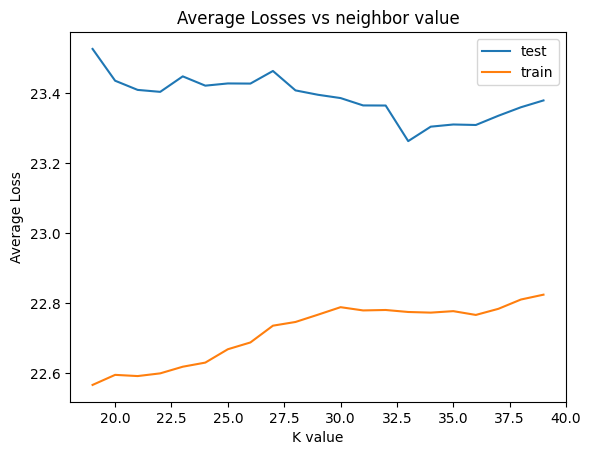

In [ ]:
ax = pd.Series(
    np.sqrt(-grid_cv.cv_results_["mean_test_score"]),
    index=range(19, 40)).plot.line(label="test")
ax.set_title("Average Losses vs neighbor value")
pd.Series(
    np.sqrt(-grid_cv.cv_results_["mean_train_score"]),
    index=range(19, 40)).plot.line(ax=ax, label="train")
ax.legend()
ax.set_ylabel("Average Loss")
ax.set_xlabel("K value")
plt.show()

_YOUR INTERPRETATION HERE_

The grid's best_params_ attribute tells us that the k-value is optimized at 33 neighbors. We can confirm this by looking at the plot of the test and training error, where we can see that the test error reaches a local minimum when k has a value of 33. Note that since we are using a negative mean squared error, we have plotted the "losses" in accuracy, so a lower test error is better.

What this tells us is that with our selected parameters of the manhattan distance metric and the StandardScaler scaler choice, the optimal value of k is 33. It is important to note that this value could vary for a different combination of parameters.

## Submission Instructions

- Restart this notebook and run the cells from beginning to end.
  - Go to Runtime > Restart and Run All.

In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Open `_NOTEBOOK.html` in your browser, and save it as a PDF.
    - Go to File > Print > Save as PDF.
- Double check that all of your code and output is visible in the saved PDF.
- Upload the PDF to [Gradescope](https://www.gradescope.com/courses/694907).
    - Please be sure to select the correct pages corresponding to each question.